This Script trains the 5 word-level Siamese Models 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Pip installs
!pip install tensorflow_io==0.23.1
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.1 MB 6.8 MB/s 
     |████████████████████████████████| 2.1 MB 65.7 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.26.0
    Uninstalling tensorflow-io-gcs-filesystem-0.26.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.26.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#More Imports
import os
import pandas as pd
import glob
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Layer, MaxPooling2D, Input
from tensorflow.keras.metrics import BinaryAccuracy, Recall
import numpy as np


In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Start by defining methods to convert a wave input into a standard spectrogram

In [ ]:
# This Method takes a file path and returns the sample rate and the sound wave as a tensor

def load_wav_16k_mono(filename):
  # Load encoded wav file
  file_contents = tf.io.read_file(filename)
  # Decode wav (Tensors by channels)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  # Removing trailing axis
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  # Downsample to 16000Hz
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav, sample_rate


In [ ]:
# This method takes data from two datasets, the anchor and the testing/validation set
# It returns two spectrograms and a label denoting if the two spectrograms are of the same word or not

def get_spectrogram_and_label(anchor_start, anchor_end, anchor_filepath, val_start, val_end, val_filepath, label):

  #Get full wave using load_wav_16k_mono
  anchor_wav, anchor_rate = load_wav_16k_mono(anchor_filepath)
  val_wav, val_rate = load_wav_16k_mono(val_filepath)

  #Slice the wave tensors by where the word starts and end
  anchor_start_index = anchor_start * tf.cast(anchor_rate, dtype=('float64'))
  anchor_end_index = anchor_end * tf.cast(anchor_rate, dtype=('float64'))
  anchor_wav = anchor_wav[int(anchor_start_index):int(anchor_end_index)]
  val_start_index = val_start * tf.cast(val_rate, dtype=('float64'))
  val_end_index = val_end * tf.cast(val_rate, dtype=('float64'))
  val_wav = val_wav[int(val_start_index):int(val_end_index)]

  #Get the first 1.5 second of wav to standardize the size of the wave (1.5s*16000Hz=24000)
  anchor_wav = anchor_wav[:24000]
  val_wav = val_wav[:24000]

  #if wave shorter than 1.5 seconds, pad with zeros
  anchor_zero_padding = tf.zeros([24000]-tf.shape(anchor_wav), dtype=tf.float32)
  anchor_wav = tf.concat([anchor_zero_padding, anchor_wav], 0)
  val_zero_padding = tf.zeros([24000]-tf.shape(val_wav), dtype=tf.float32)
  val_wav = tf.concat([val_zero_padding, val_wav], 0)  

  #Get spectrograms using tf.singal.stft()
  anchor_spectrogram = tf.signal.stft(anchor_wav, frame_length=480, frame_step=100)                
  anchor_spectrogram = tf.abs(anchor_spectrogram)
  anchor_spectrogram = tf.expand_dims(anchor_spectrogram, axis=2)
  val_spectrogram = tf.signal.stft(val_wav, frame_length=480, frame_step=100)        
  val_spectrogram = tf.abs(val_spectrogram)
  val_spectrogram = tf.expand_dims(val_spectrogram, axis=2)

  return anchor_spectrogram, val_spectrogram, label

Next we define the architecture of the siamese models

In [ ]:
# This method defines the embedding part of the Siamese Model
# It has four convolutional layers, three max pooling layers a flatten and a dense layer.

def make_embedding():

  model = Sequential()
  
  model.add(Conv2D(64, (10,10), activation='relu', input_shape=(236, 257, 1)))
  model.add(MaxPooling2D(2,2))

  model.add(Conv2D(128, (7,7), activation='relu'))
  model.add(MaxPooling2D(2,2))

  model.add(Conv2D(128, (4,4), activation='relu'))
  model.add(MaxPooling2D(2,2))

  model.add(Conv2D(256, (4,4), activation='relu'))

  model.add(Flatten())

  model.add(Dense(3072, activation='sigmoid'))

  model._name="embedding"

  return model

In [ ]:
# The class defines the distance layer of the Siamese Network,
# It calculates the distance between the anchor and the test/validation embedding

class L1Dist(Layer):

  def __init__(self, **kwargs):
    super().__init__()

  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
# This method combines the embedding and distance layers to create the Siamese model

def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(236, 257, 1))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(236, 257, 1))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

The below methods define how the models will be trained, this had to be defined manually as there is no automatic training for a bespoke model such as our Siamese Network.

In [ ]:
# This tensorflow function defines the training step
# It gets the batch of anchor and the validation/test spectrograms, and predictes them with the siamese model
# It then returns the loss 

@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and validation/test spectrogram
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass through the siamese model (prediction)
        yhat = siamese_model(X, training=True)
        # Calculate loss (is the )
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [ ]:
# This method defines the training process
# It takes in the data and the number of epochs and returns trainig metrics such as loss recall and accuracy.

def train(data, EPOCHS):
    # Create training metric lists to populate later
    epoch_list = []
    loss_list = []
    # r_list will record recall
    r_list = []
    # a_list will record accuracy
    a_list = []

    # Training loop
    for epoch in range(1, EPOCHS+1):
        #Create epoch progress bar
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        a = BinaryAccuracy()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            a.update_state(batch[2], yhat)
            progbar.update(idx+1)

        epoch_list.append(epoch)
        loss_list.append(loss.numpy())
        r_list.append(r.result().numpy())
        a_list.append(a.result().numpy())

        print(loss.numpy(), r.result().numpy(), a.result().numpy())

    return epoch_list, loss_list, r_list, a_list
        

In [ ]:
# This method manages training multiple models, it's parsed variable "each" takes in the word that is to be trained on
# It reads in the data CSV, preprocesses it (drops anything not related to "each") and uses the get_spectrogram_and_label method to get spectrograms
# It also upsamples either TD or SSD datasets to ensure that there is an even split between the two diagnoses

def train_model(each, embedding):

  ## Read in dataframe
  df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SummerProject/data/siamese_1_GPU_DF.csv', index_col=1)
  df = df.drop(columns='Unnamed: 0')

  ## Drop anything that isn't the word
  df_each = df.drop(df[df.word != each].index)

  ## Split into ssd and td
  df_each_td = df_each.drop(df_each[df_each.td_ssd != "td"].index)
  df_each_ssd = df_each.drop(df_each[df_each.td_ssd != "ssd"].index)

  anchor, positive = train_test_split(df_each_td, test_size=0.5)

  # If the negative (SSD) dataset is larger than the postive (TD) dataset, randomly upsample the TD dataset to match
  # Else upsample SSD to match TD size
  negative = df_each_ssd
  return_size = 0
  other_size = 0
  if negative.shape[0] > positive.shape[0]: 
    ratio = (negative.shape[0] - positive.shape[0])/positive.shape[0]
    positive = pd.concat([positive, positive.sample(frac=ratio, replace=True)])
    positive = positive.sample(frac=1)
    ratio = (negative.shape[0] - anchor.shape[0])/anchor.shape[0]
    anchor = pd.concat([anchor, anchor.sample(frac=ratio, replace=True)])
    anchor = anchor.sample(frac=1)
    bin = 1
    return_size = positive.shape[0]
    other_size = negative.shape[0]
  else:
    ratio = (positive.shape[0] - negative.shape[0])/negative.shape[0]
    negative = pd.concat([negative, negative.sample(frac=ratio, replace=True)])
    negative = negative.sample(frac=1)
    bin = 0
    return_size = positive.shape[0]
    other_size = negative.shape[0]

  #create tensors from dataframe to pass to get_spectrogram_and_label method
  anchor_start_tensor = tf.data.Dataset.from_tensor_slices(anchor['Start'])
  anchor_end_tensor = tf.data.Dataset.from_tensor_slices(anchor['End'])
  anchor_file_tensor = tf.data.Dataset.from_tensor_slices(anchor['filepath'])

  positive_start_tensor = tf.data.Dataset.from_tensor_slices(positive['Start'])
  positive_end_tensor = tf.data.Dataset.from_tensor_slices(positive['End'])
  positive_file_tensor = tf.data.Dataset.from_tensor_slices(positive['filepath'])

  negitive_start_tensor = tf.data.Dataset.from_tensor_slices(negative['Start'])
  negitive_end_tensor = tf.data.Dataset.from_tensor_slices(negative['End'])
  negitive_file_tensor = tf.data.Dataset.from_tensor_slices(negative['filepath'])

  ## Zipping anchors with postives and negatives
  positives = tf.data.Dataset.zip((anchor_start_tensor, anchor_end_tensor, anchor_file_tensor, positive_start_tensor, positive_end_tensor, positive_file_tensor, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
  negatives = tf.data.Dataset.zip((anchor_start_tensor, anchor_end_tensor, anchor_file_tensor, negitive_start_tensor, negitive_end_tensor, negitive_file_tensor, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
  data = positives.concatenate(negatives)

  # Map data into spectrograms and labels
  data = data.map(get_spectrogram_and_label)
  data = data.cache()
  data = data.shuffle(buffer_size=10000)

  # Split into test/train
  train_data = data.take(round(len(data)*.7))
  train_data = train_data.batch(16)
  train_data = train_data.prefetch(8)

  test_data = data.skip(round(len(data)*.7))
  test_data = test_data.take(round(len(data)*.3))
  test_data = test_data.batch(16)
  test_data = test_data.prefetch(8)

  ### This part of the method starts the training ###
  
  EPOCHS = 50
  epoch_list, loss_list, r_list, a_list = train(train_data, EPOCHS)

  # Create list to populate with training metrics
  word_list = [each] * EPOCHS
  training_results = []
  training_results.append((word_list, epoch_list, loss_list, r_list, a_list))
  training_results = [x for xs in training_results for x in xs]

  # Use testing 
  r = Recall()
  a = BinaryAccuracy()

  for test_input, test_val, y_true in test_data.as_numpy_iterator():
      yhat = siamese_model.predict([test_input, test_val])
      r.update_state(y_true, yhat)
      a.update_state(y_true, yhat)

  # Save each siamese model, each model takes 1.61GB and thus takes a long time to save
  # siamese_model.save(each)

  print(each, r.result().numpy(), a.result().numpy())

  return r.result().numpy(), a.result().numpy(), return_size, other_size, bin, training_results

In [ ]:
# This method is used to unpack the results of the training stage for each model

def list_comp(training_results, training_metrics):

  word_list = training_results[0] + training_metrics[0]
  epoch_list = training_results[1] + training_metrics[1]
  loss_list = training_results[2] + training_metrics[2]
  r_list = training_results[3] + training_metrics[3]
  a_list = training_results[4] + training_metrics[4]
  
  trained = []
  trained.append([word_list, epoch_list, loss_list, r_list, a_list])
  trained = [x for xs in trained for x in xs]

  return trained

The core code that initiates hyper parameters and training

In [ ]:
# Core code (not in a method)

# Compute tensor flow functions as they are made, helps with memory managment
tf.config.run_functions_eagerly(True)

# Create results lists to be filled
results = []
training_results = [[],[],[],[],[]]

# Define the words the models should be trained on, this list could be extended easily
common = ['SWING', 'UMBRELLA', 'QUEEN', 'HELICOPTER', 'ORANGE']
# Create Embedding
embedding = make_embedding()
# Create Siamese_model
siamese_model = make_siamese_model()

# Define loss and optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

# Iterates over each word creating 5 distinct models
for each in common:
  recall, accuracy, DSsize, other, bin, training_metrics = train_model(each, embedding)
  results.append((each, recall, accuracy, DSsize, other, bin))
  training_results = list_comp(training_results, training_metrics)

training_metrics_df = pd.DataFrame(training_results)
training_metrics_df = training_metrics_df.T
training_metrics_df.columns=['word', 'epoch', 'loss', 'recall', 'accuracy']
results_df = pd.DataFrame(results, columns=['Word', 'Recall', 'Accuracy', 'DSsize', 'other', 'bin'])#


In [ ]:
# results_df contains the final emtrics for each model
results_df

,Word,Recall,Accuracy,DSsize,other,bin
0,SWING,0.933333,0.643750,52,52,1
1,UMBRELLA,0.894737,0.958333,64,64,1
2,QUEEN,1.000000,1.000000,48,48,1
3,HELICOPTER,0.850000,0.937500,66,66,0
4,ORANGE,0.882353,0.937500,56,56,1


In [ ]:
# training_metrics_df contains metrics for each epoch
training_metrics_df

,word,epoch,loss,recall,accuracy
0,SWING,1,0.686215,0.0,0.555556
1,SWING,2,0.638044,0.083333,0.545833
2,SWING,3,0.561416,0.105263,0.501389
3,SWING,4,0.6175,0.026316,0.470833
4,SWING,5,0.61612,0.166667,0.508333
...,...,...,...,...,...
245,ORANGE,46,0.403971,0.785714,0.833929
246,ORANGE,47,0.438165,0.864865,0.898214
247,ORANGE,48,0.461257,0.846154,0.883929
248,ORANGE,49,0.34156,0.891892,0.9375


In [ ]:
# Write metrics to csv
#training_metrics_df.to_csv('/content/drive/My Drive/Colab Notebooks/SummerProject/data/siamese_1_GPU_training_metrics.csv', index=True)

Creating a few graphics

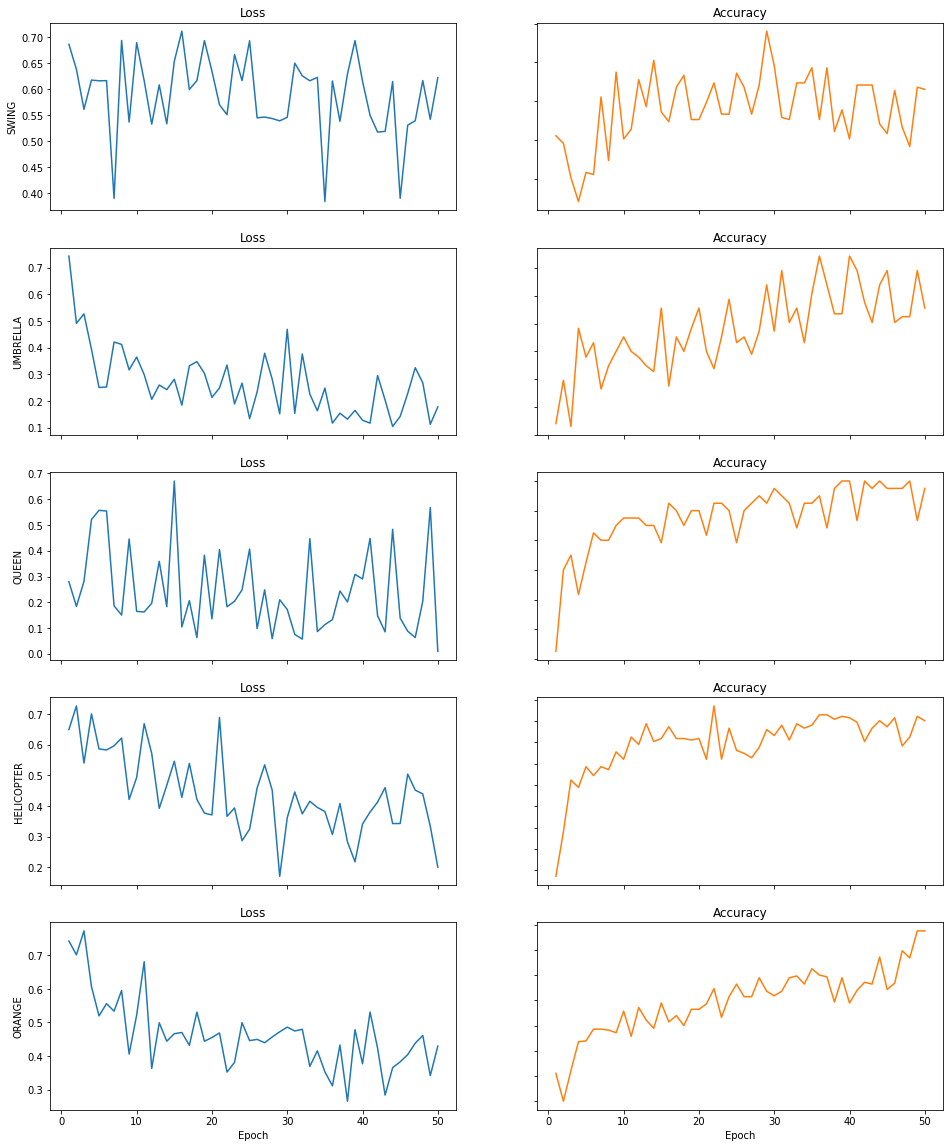

In [ ]:
# Create the pyplots of the accuracy and loss metrics

plt.rcParams["figure.figsize"] = (16,20) #100

x = np.linspace(1, 50, 50)

fig, axs = plt.subplots(5, 2)

for i in range(len(common)):

  y = training_metrics_df.loc[training_metrics_df['word'] == common[i]].loss
  axs[i, 0].plot(x, y)
  axs[i, 0].set_title('Loss')
  axs[i, 0].set_ylabel(common[i])

  y = training_metrics_df.loc[training_metrics_df['word'] == common[i]].accuracy
  axs[i, 1].plot(x, y, 'tab:orange')
  axs[i, 1].set_title('Accuracy')


for ax in axs.flat:
    ax.set(xlabel='Epoch')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

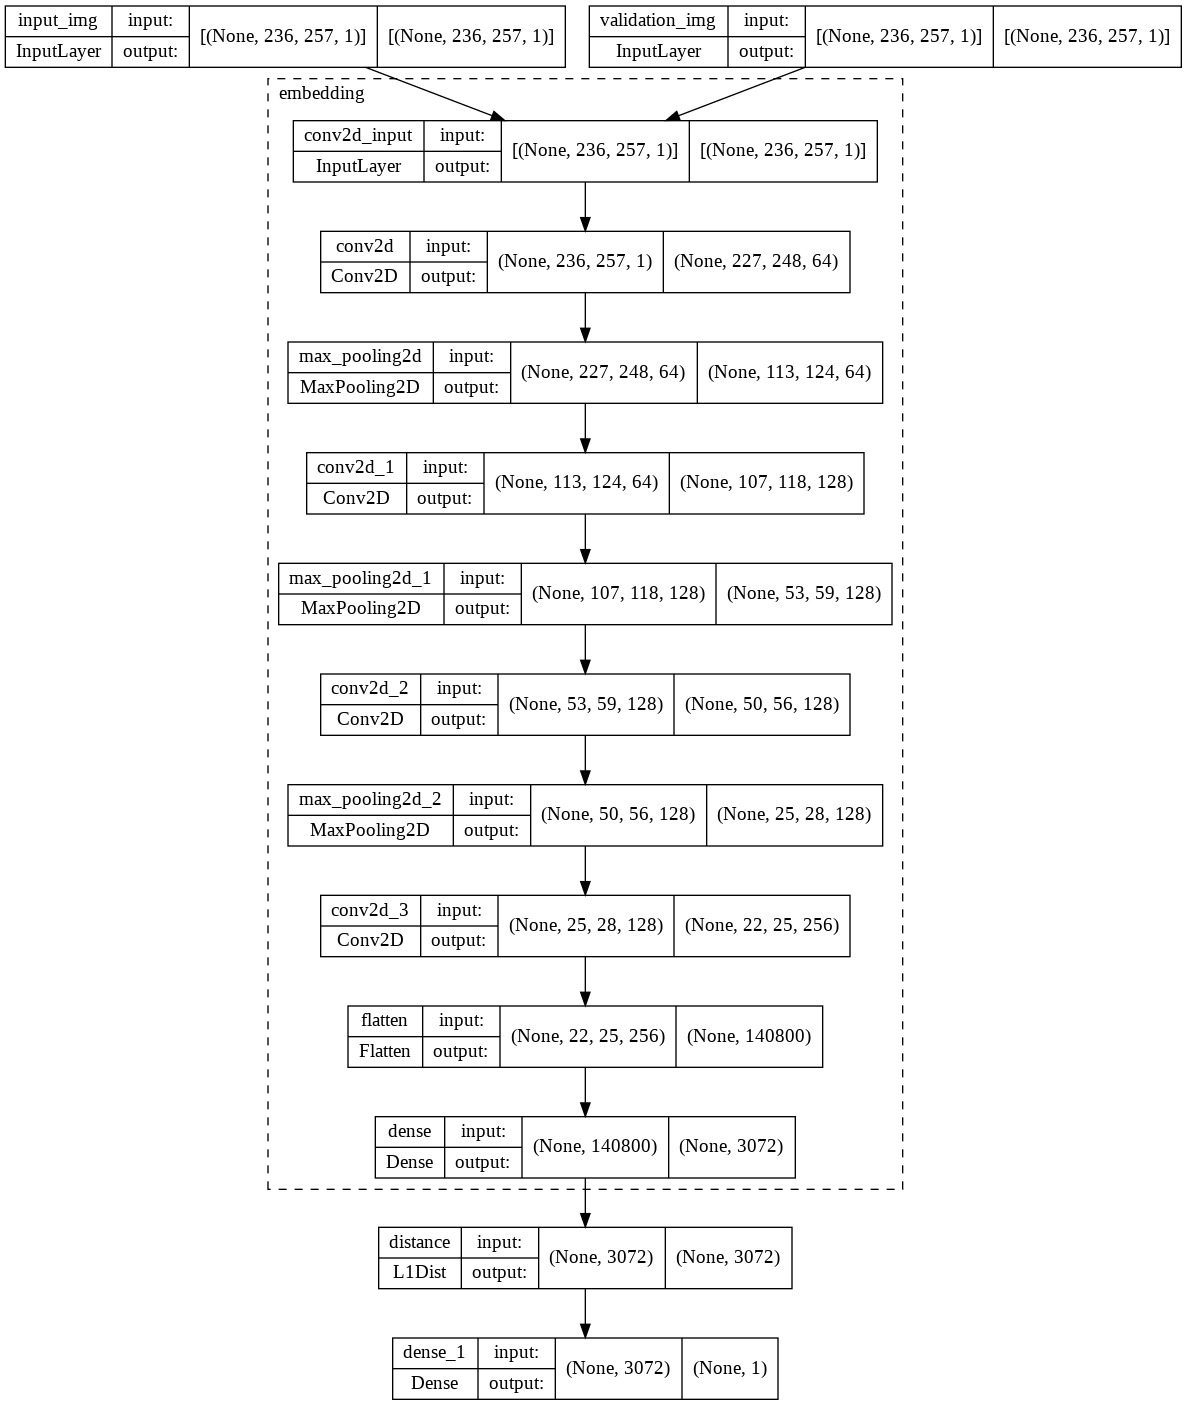

In [ ]:
# Create the diagram denoting the siamese_model architecture

tf.keras.utils.plot_model(
    siamese_model, show_shapes=True, expand_nested=True)